In [1]:
#importing all necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

In [2]:
#import os

def load_images_from_folder(foldername):
    images = []
    for filename in os.listdir(foldername):
        img = cv2.imread(os.path.join(foldername,filename))
        if img is not None:
            images.append(img)
    return images
img_list=load_images_from_folder("C:\\Users\\vijja\\Downloads\\archive (10)\\CASIA2\\Au")

In [3]:
len(img_list[0])

256

## 

In [4]:
data_dir = r'C:\Users\vijja\Downloads\archive (10)\CASIA2\Au'
train_dir = os.path.join(data_dir)


In [5]:
#class labels
image_type = ['Authenticated','Tampered']

Performing Error level Analysis

In [6]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

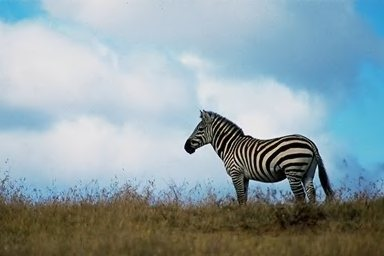

In [7]:
real_image_path = "C:\\Users\\vijja\\Downloads\\archive (10)\\CASIA2\\Au\\Au_ani_00001.jpg"
Image.open(real_image_path)

ELA converted image

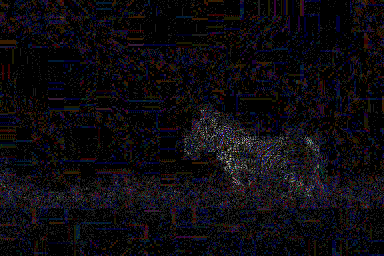

In [8]:
convert_to_ela_image(real_image_path, 85)

Resizing image and converting it for making suitable to model

In [9]:
image_size = (224, 224)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten() / 255.0

In [10]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

Getting authenticated images

In [11]:
import random
count = 0
path = 'C:\\Users\\vijja\\Downloads\\archive (10)\\CASIA2\\Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
#         count+=1
#         if count < 1000:
#             pass
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)  
        if len(Y) % 2000 == 0:
            print(f'Processing {len(Y)} images')
            break
    if len(Y) % 2000 == 0:
        break

random.shuffle(X)
# X = X[:2100]
# Y = Y[:2100]
print(len(X), len(Y))

Processing 2000 images
2000 2000


In [12]:
x_t, y_t = [], []

Getting tampered images

In [13]:
path = 'C:\\Users\\vijja\\Downloads\\archive (10)\\CASIA2\\Tp'
count = 0
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
#         count += 1
#         if count < 1000:
#             pass
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
        if len(Y) % 4000 == 0:
            print(f'Processing {len(Y)} images')
            break
    if len(Y) % 4000 == 0:
        break

print(len(X), len(Y))

Processing 4000 images
4000 4000


In [14]:
au,tp=0,0
for i in Y:
    if(i==1):
        au+=1
    else:
        tp+=1
print(tp,au)

2000 2000


In [15]:
from keras.utils.np_utils import to_categorical

In [16]:
#shuffling of images
from sklearn.utils import shuffle
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

In [17]:
#reshaping the image array
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 224, 224, 3)

In [18]:
#splitting the dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=42)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3200 3200
800 800


In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import plot_model

In [20]:
tf.keras.applications.resnet50.ResNet50(include_top=False,input_tensor=None,input_shape=(224,224,3), pooling=None,classes=1000)

In [21]:
model = ResNet50()

In [22]:

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [23]:
last_layer = model.get_layer('conv2_block3_out')
last_output = last_layer.output

In [24]:
x = Flatten()(last_output)
x = Dense(64, activation='relu', name='FC_1')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax', name='softmax')(x)

new_model = Model(inputs=model.input, outputs=x)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0,
                               patience=5,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)

In [26]:
new_model.compile (
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [27]:
batch_size =30
epochs = 15

history = new_model.fit(
    X_train, Y_train,
    epochs=epochs,
    
    batch_size = batch_size,
    validation_data=(X_val, Y_val),
    verbose=2, callbacks=[early_stopping])

Epoch 1/15
107/107 - 372s - loss: 0.3479 - accuracy: 0.8712 - val_loss: 5.4526 - val_accuracy: 0.4963 - 372s/epoch - 3s/step
Epoch 2/15
107/107 - 370s - loss: 0.1476 - accuracy: 0.9494 - val_loss: 1.3037 - val_accuracy: 0.4963 - 370s/epoch - 3s/step
Epoch 3/15
107/107 - 354s - loss: 0.0851 - accuracy: 0.9759 - val_loss: 8.8425 - val_accuracy: 0.4963 - 354s/epoch - 3s/step
Epoch 4/15
107/107 - 355s - loss: 0.0557 - accuracy: 0.9819 - val_loss: 3.2965 - val_accuracy: 0.4963 - 355s/epoch - 3s/step
Epoch 5/15
107/107 - 356s - loss: 0.0499 - accuracy: 0.9862 - val_loss: 6.6868 - val_accuracy: 0.4963 - 356s/epoch - 3s/step
Epoch 6/15
Restoring model weights from the end of the best epoch: 1.
107/107 - 346s - loss: 0.0390 - accuracy: 0.9881 - val_loss: 0.8126 - val_accuracy: 0.4850 - 346s/epoch - 3s/step
Epoch 6: early stopping


In [33]:
for layer in model.layers:
    weights = layer.get_weights()
    print(weights)

[]
[]
[array([[[[ 3.12154330e-02, -2.11137570e-02, -2.16013798e-03, ...,
          -1.63812805e-02, -6.17974550e-02, -1.18955197e-02],
         [ 1.18371584e-02,  4.12259735e-02,  9.72146541e-03, ...,
           3.26581229e-03,  5.39683178e-03,  1.38790756e-02],
         [-2.81205797e-03, -5.29549345e-02,  1.01026325e-02, ...,
           7.26982811e-03,  2.63430700e-02, -4.38975636e-03]],

        [[ 2.23117154e-02, -1.57932118e-02, -3.11555434e-03, ...,
          -1.06954144e-03, -1.69929564e-02,  2.39936868e-03],
         [ 1.99426692e-02,  4.97735329e-02,  1.01742987e-02, ...,
           2.07717661e-02,  2.05162936e-03, -2.38203947e-02],
         [ 2.35340092e-02, -4.39008065e-02,  1.33039756e-02, ...,
           7.29199313e-03, -2.20950544e-02, -8.26315489e-03]],

        [[ 8.05999618e-03, -2.03064624e-02,  8.52649193e-03, ...,
           4.64555481e-03,  1.84222520e-03, -4.90277447e-03],
         [ 3.54700945e-02,  4.02958356e-02,  8.00326001e-03, ...,
           1.84315871e-02, 

In [34]:
model.save("resnet.h5")